# Anomaly Detection Refinements

# IPOC measurement lengths

IPOC triggers can be 10 seconds apart.
But how long does each measurment "cycle" last?

In [78]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import sys
sys.path.insert(0, '..')
from database import mongo_client
from anomaly_detection import preprocessing as ad_pp
%matplotlib inline
matplotlib.style.use('ggplot')
from IPython.display import display
# auto-load changes in imported modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [79]:
client = mongo_client.CERNMongoClient()
start_date = '2016-04-16 00:00:00.000000'
df = client.query_resample("MKI.UA23.IPOC.AB1:T_LENGTH", None, "$gte", start_date)
index = df.index.round("S")
df["timestamps"] = index

Fetching data for pattern MKI.UA23.IPOC.AB1:T_LENGTH
Fetching data for MKI.UA23.IPOC.AB1:T_LENGTH


### Visually

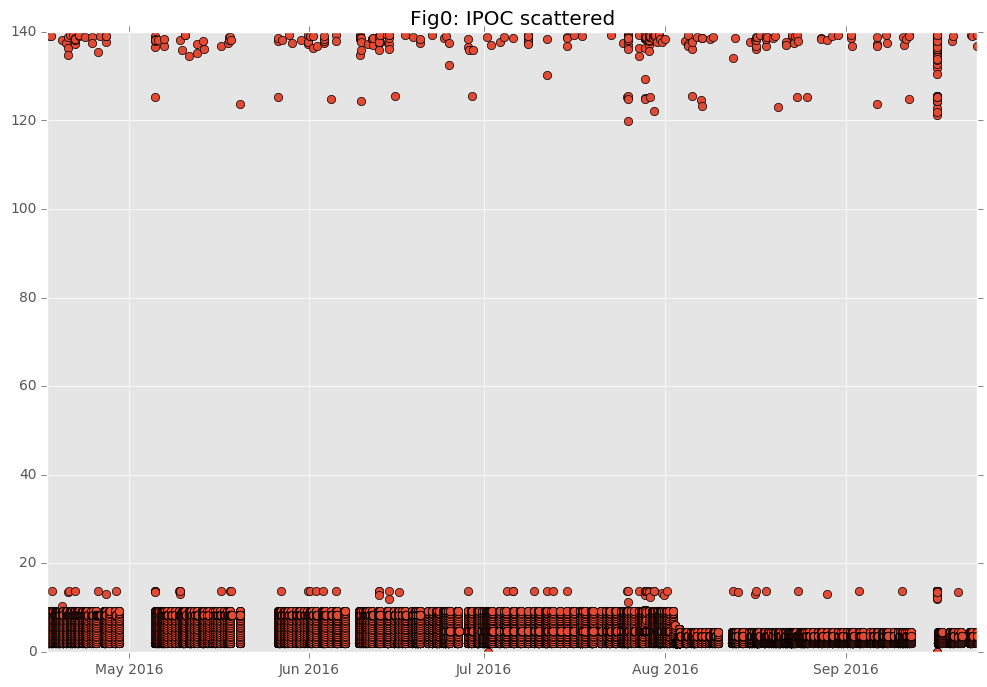

In [80]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.plot_date(x=df["timestamps"], y=df["MKI.UA23.IPOC.AB1:T_LENGTH"])
plt.title("Fig0: IPOC scattered")

Hard to detect visually, only long gaps can be detected.

### Code

In [81]:
# http://stackoverflow.com/a/26916647
cluster = (df["timestamps"].diff() > pd.Timedelta(minutes=10)).cumsum()
dfs = [v for k, v in df.groupby(cluster)]

IPOC_lenghts = []
for clust in dfs:
    if len(clust)!=1:
        IPOC_lenghts.append(clust["timestamps"].iloc[-1] - clust["timestamps"].iloc[0])

IPOC_lenghts = pd.Series(IPOC_lenghts)

IPOC clusters are ended when the time between 2 IPOC measurements exceeds 10 minutes. Not counting clusters of length 1 (isolated IPOC measurements).

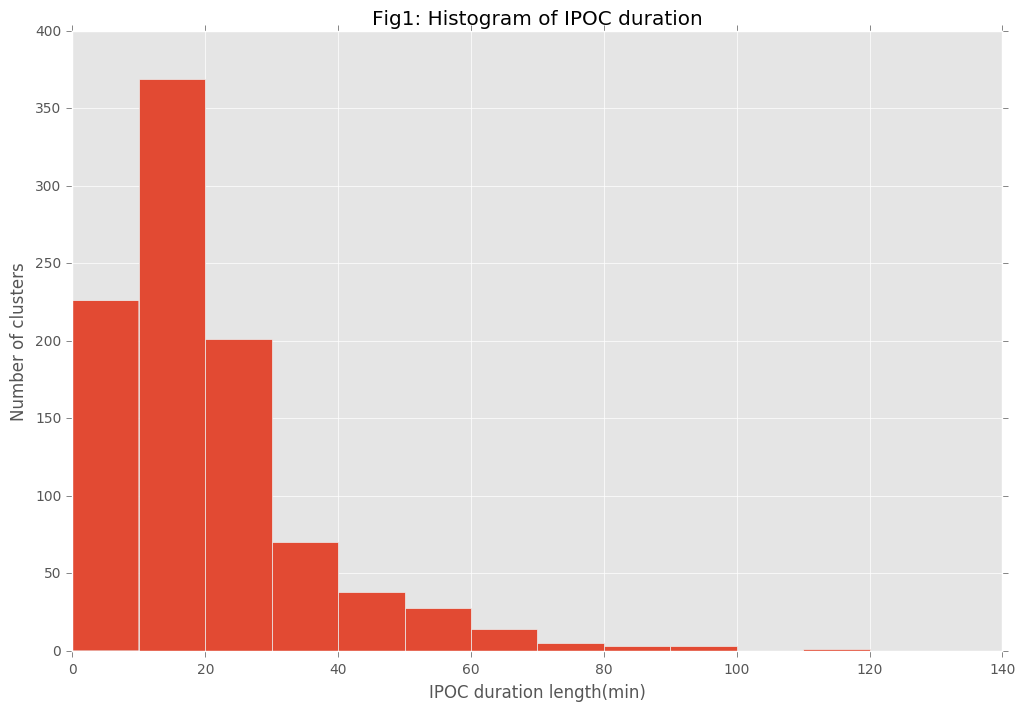

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
(IPOC_lenghts / pd.Timedelta(minutes=1)).hist(bins=xrange(0, 150, 10))
plt.xlabel('IPOC duration length(min)')
plt.ylabel('Number of clusters')
plt.title("Fig1: Histogram of IPOC duration")

From this figure it seems better to expand the sliding windows to 20 minutes. Next step is to check the variation in the sliding windows over each cluster.

## Inspecting Anomalies

### Timestamps

In [83]:
ELB = client.query_resample("MKI.ELOGBOOK_tagged", None, "$gte", start_date)

Fetching data for pattern MKI.ELOGBOOK_tagged
Fetching data for MKI.ELOGBOOK_tagged


In [84]:
ELB = ELB.join(ELB['MKI.ELOGBOOK_tagged'].apply(pd.Series))
ELB.drop('MKI.ELOGBOOK_tagged', axis=1, inplace=True)
ELB.drop("C0", axis=1, inplace=True)
ELB["marker"] = 0

In [85]:
display(ELB.head())

EVENTDATE EVENT_ID      PATH  \
timestamps                                                    
2016-04-23 04:00:00  23/04/2016 06:00:00  2098246  LHC.MKI8   
2016-04-23 10:15:28  23/04/2016 12:15:28  2098379  LHC.MKI8   
2016-04-24 05:19:36  24/04/2016 07:19:36  2098811  LHC.MKI8   
2016-04-24 12:03:20  24/04/2016 14:03:20  2098949  LHC.MKI8   
2016-04-26 10:00:00  26/04/2016 12:00:00  2100547  LHC.MKI8   

                                                   SUBSTR_COMMENT_512_  \
timestamps                                                               
2016-04-23 04:00:00  Piquet contact me for the MKI8 problem with th...   
2016-04-23 10:15:28  At the same moment as the LBDS XPOC fault, the...   
2016-04-24 05:19:36  CCC LHC calls for MKI8 faulty. Same problem as...   
2016-04-24 12:03:20  CCC calls, again SVM fault for KTC6 rack. I tr...   
2016-04-26 10:00:00  High vacuum in MKI8d-Q5 interconnect during sc...   

                          TAG                   USERNAME VALUE  marker  
timestamps                                                              
2016-04-23 04:00:00     fault  christophe.boucly@cern.ch  MKI8       0  
2016-04-23 10:15:28     fault                   pvantrap  MKI8       0  
2016-04-24 05:19:36     fault                   pvantrap  MKI8       0  
2016-04-24 12:03:20     fault                   pvantrap  MKI8       0  
2016-04-26 10:00:00  research        mike.barnes@cern.ch  MKI8       0

In [86]:
anom = ELB[ELB["TAG"]=="anomaly"]
display(anom.head())

EVENTDATE EVENT_ID      PATH  \
timestamps                                                    
2016-05-30 14:00:00  30/05/2016 16:00:00  2118913  LHC.MKI8   
2016-06-05 17:18:00  05/06/2016 19:18:00  2122744  LHC.MKI8   
2016-06-18 19:59:00  18/06/2016 21:59:00  2130953  LHC.MKI8   
2016-06-19 13:14:00  19/06/2016 15:14:00  2131267  LHC.MKI2   
2016-06-30 21:23:00  30/06/2016 23:23:00  2138252  LHC.MKI2   

                                                   SUBSTR_COMMENT_512_  \
timestamps                                                               
2016-05-30 14:00:00  MKI.UA87.IPOC.AB2 Fall Time IQC check had been...   
2016-06-05 17:18:00  Thomas called me, following a call from the CC...   
2016-06-18 19:59:00  CCC called at 21:08 for a VAC INTERCONNECT int...   
2016-06-19 13:14:00  CCC called at 14h55 for a fault on MKI2.\nThe ...   
2016-06-30 21:23:00  Spark on MKI2B during SS at 51.2kV and 2.8us\n...   

                         TAG                    USERNAME VALUE  marker  
timestamps                                                              
2016-05-30 14:00:00  anomaly         mike.barnes@cern.ch  MKI8       0  
2016-06-05 17:18:00  anomaly         mike.barnes@cern.ch  MKI8       0  
2016-06-18 19:59:00  anomaly  christophe.lolliot@cern.ch  MKI8       0  
2016-06-19 13:14:00  anomaly  christophe.lolliot@cern.ch  MKI2       0  
2016-06-30 21:23:00  anomaly         mike.barnes@cern.ch  MKI2       0

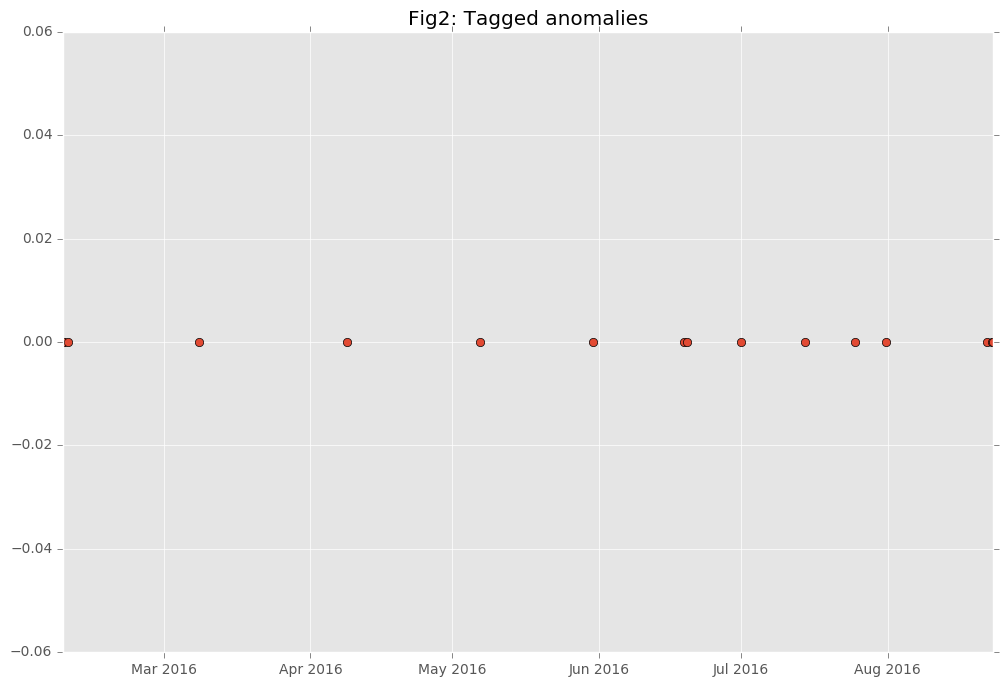

In [87]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
plt.plot_date(x=anom["EVENTDATE"], y=anom["marker"])
plt.title("Fig2: Tagged anomalies")

### Verification